## クラスタリング

与えられたデータをいくつかのグループに分ける。同じグループに分類されるものは似た傾向を持つと考えたい。
ただし、教師データはない。つまり正解はないということになる。

ここで紹介する手法は以下の四つ。

- k-means
- 階層クラスタ木
- DBSCAN
- 混合Gaussian

## k-means

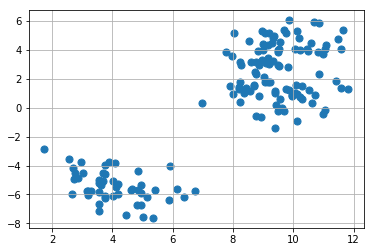

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs
X,y=make_blobs(n_samples=150, n_features=2, centers=3, random_state=4)
plt.scatter(X[:,0],X[:,1],marker='o',s=50)
plt.grid()

### アルゴリズム
- 指定された$k$個の中心点をとる。
- 各サンプルを最も近い中心点に割り当てる。
- 各クラスタの重心に中心点を移動する。
- 各サンプルを最も近い中心点に割り当て直す。

これを繰り返す。

In [2]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=3, init='random', n_init=10, max_iter=300,tol=1e-4)
y_km=km.fit_predict(X)
print('Distortion: %.2f' % km.inertia_)

Distortion: 287.88


In [3]:
km2=KMeans(n_clusters=2, init='random', n_init=10, max_iter=300,tol=1e-4)
y_km2=km2.fit_predict(X)
print('Distortion: %.2f' % km2.inertia_)

Distortion: 553.06


### k-means++
最初の$k$個の中心点をうまく選ぶ。
中心点を一つずつ追加していくときに、一様分布でなく、すでに選んでいる中心点からの距離で重みをつけた分布に従って新しい中心点を選ぶ。

$SSE=\sum_{i,j}w^{(i,j)}\vert \mu^{(j)}-x^{(i)}\vert$

In [4]:
from sklearn.cluster import KMeans
kmp=KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300,tol=1e-4)
y_kmp=kmp.fit_predict(X)
print('Distortion: %.2f' % kmp.inertia_)

Distortion: 287.88


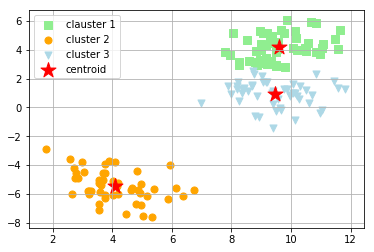

In [5]:
plt.scatter(X[y_km==0,0],X[y_km==0,1],s=50,c='lightgreen',marker='s',label='clauster 1')
plt.scatter(X[y_km==1,0],X[y_km==1,1],s=50,c='orange',marker='o',label='cluster 2')
plt.scatter(X[y_km==2,0],X[y_km==2,1],s=50,c='lightblue',marker='v',label='cluster 3')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=250,marker='*',c='red',label='centroid')
plt.legend()
plt.grid()

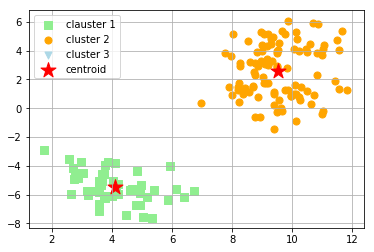

In [6]:
plt.scatter(X[y_km2==0,0],X[y_km2==0,1],s=50,c='lightgreen',marker='s',label='clauster 1')
plt.scatter(X[y_km2==1,0],X[y_km2==1,1],s=50,c='orange',marker='o',label='cluster 2')
plt.scatter(X[y_km2==2,0],X[y_km2==2,1],s=50,c='lightblue',marker='v',label='cluster 3')
plt.scatter(km2.cluster_centers_[:,0],km2.cluster_centers_[:,1],s=250,marker='*',c='red',label='centroid')
plt.legend()
plt.grid()

## クラスタリングの性能評価
- エルボー法
- シルエット図

### エルボー法
$k$-means法に使える。
Distrotionに基づいて最適な$k$を決定する。
$k$を増やせばDistorsionは$0$になる。
$k$の増加に対して、Distortionがいつ最も変化するか。

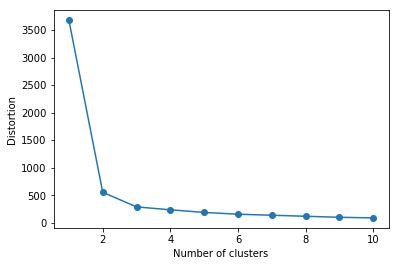

In [7]:
distortions=[]
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

### シルエット図
一般のクラスタリング手法に対して使える。
シルエット係数$s^{(i)}$を各サンプル$x^{(i)}$ごとに以下のように計算する。
$a^{(i)}$を同じクラスタの他のサンプルとの平均距離、$b^{(i)}$を最も近いクラスタの全てのサンプルとの平均距離、
$s^{(i)}=\frac{b^{(i)}-a^{(i)}}{\max\{b^{(i)},a^{(i)}\}}$とする。

In [12]:
#クラスタリング結果からシルエット図を出力する関数を定義
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
def plot_silhouette(X,y_cl):
    cluster_labels=np.unique(y_cl)
    n_clusters=cluster_labels.shape[0]
    silhouette_vals=silhouette_samples(X,y_cl,metric='euclidean')
    y_ax_upper,y_ax_lower=0,0
    yticks=[]
    for i,c in enumerate(cluster_labels):
        c_silhouette_vals=silhouette_vals[y_cl==c]
        c_silhouette_vals.sort()
        y_ax_upper+=len(c_silhouette_vals)
        color=cm.jet(float(i)/n_clusters)
        plt.barh(range(y_ax_lower,y_ax_upper),c_silhouette_vals,
                 height=1.0,edgecolor='none',color=color)
        yticks.append((y_ax_lower+y_ax_upper)/2)
        y_ax_lower+=len(c_silhouette_vals)
    silhouette_avg=np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,color='red',linestyle='--')
    plt.yticks(yticks,cluster_labels+1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')

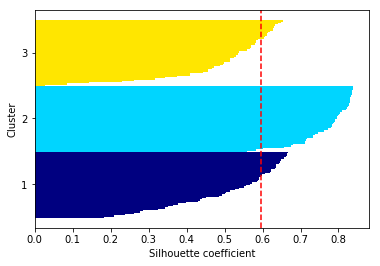

In [13]:
plot_silhouette(X,y_km)

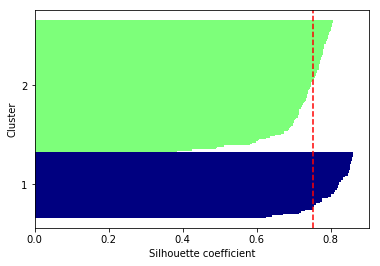

In [14]:
plot_silhouette(X,y_km2)

## 階層的クラスタリング
完全連結法に基づく凝集型階層的クラスタリングについて。
- 全てのサンプルの距離行列を計算する
- 各サンプルを単一のクラスタとみなす
- クラスタ間の距離をクラスタのメンバ間の距離の最大とし、最も近いクラスタを結合する
- 距離行列を更新する

というステップをクラスタが一つになるまで繰り返す。

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
variables=['X','Y','Z']
labels=['ID_0','ID_1','ID_2','ID_3','ID_4']
X=np.random.random_sample([5,3])*10
df=pd.DataFrame(X,columns=variables,index=labels)
df

,X,Y,Z
ID_0,4.823929,0.598136,5.132496
ID_1,8.380404,3.320027,5.984719
ID_2,8.046841,5.498824,7.700989
ID_3,0.041411,9.462459,5.119820
ID_4,3.140375,7.254212,7.501571


In [16]:
from scipy.spatial.distance import pdist,squareform
row_dist=pd.DataFrame(squareform(pdist(df,metric='euclidean')),columns=labels,index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.558892,6.403207,10.072183,7.262935
ID_1,4.558892,0.000000,2.793565,10.393091,6.725813
ID_2,6.403207,2.793565,0.000000,9.298374,5.214841
ID_3,10.072183,10.393091,9.298374,0.000000,4.489173
ID_4,7.262935,6.725813,5.214841,4.489173,0.000000


,row label 1,row label 2,distance,no. of items in cluster
cluster 1,1.0,2.0,2.793565,2.0
cluster 2,3.0,4.0,4.489173,2.0
cluster 3,0.0,5.0,6.403207,3.0
cluster 4,6.0,7.0,10.393091,5.0


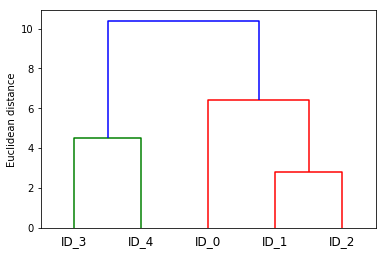

In [17]:
from scipy.cluster.hierarchy import linkage,dendrogram
row_clusters=linkage(pdist(df,metric='euclidean'),method='complete')
#row_clusters=linkage(df.values,method='complete',metric='euclidean')
row_dendr=dendrogram(row_clusters,labels=labels)
plt.ylabel('Euclidean distance')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2','distance','no. of items in cluster'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


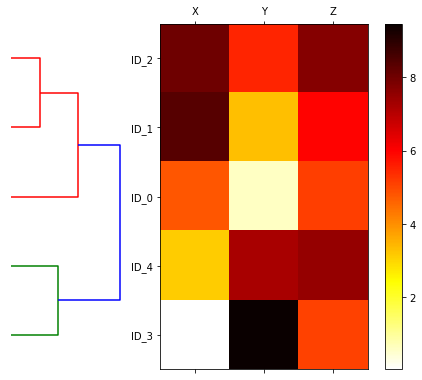

In [18]:
fig=plt.figure(figsize=(8,8),facecolor='white')
axd=fig.add_axes([0.09,0.1,0.2,0.6])
row_dendr=dendrogram(row_clusters,orientation='right')
df_rowclust=df.ix[row_dendr['leaves'][::-1]]
axm=fig.add_axes([0.23,0.1,0.6,0.6])
cax=axm.matshow(df_rowclust,interpolation='nearest',cmap='hot_r')
axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)
fig.colorbar(cax)
axm.set_xticklabels(['']+list(df_rowclust.columns))
axm.set_yticklabels(['']+list(df_rowclust.index))

In [19]:
from sklearn.cluster import AgglomerativeClustering
ac=AgglomerativeClustering(n_clusters=2,affinity='euclidean',linkage='complete')
labels=ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [0 0 0 1 1]


## DBSCAN
半径$\epsilon$と個数MinPtsを指定する。
- コア点とは半径$\epsilon$以内にMinPts以上の点があること
- ボーダー点とはコア点ではなく、あるコア点の半径$\epsilon$以内に存在する点
- ノイズ点とは上記以外

コア点の距離が$\epsilon$の場合は同じクラスタに、そうでない場合は別のクラスタにする。
ボーダー点はそれが属するコア点のクラスタにする。

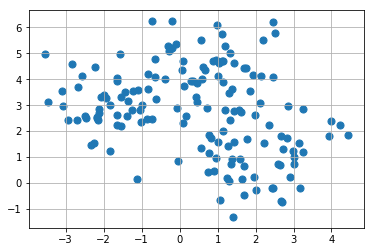

In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
X,y=make_blobs(n_samples=150, n_features=2, centers=3, random_state=0)
plt.scatter(X[:,0],X[:,1],marker='o',s=50)
plt.grid()

(-1.3257394922864898, 6.2545627226801797)

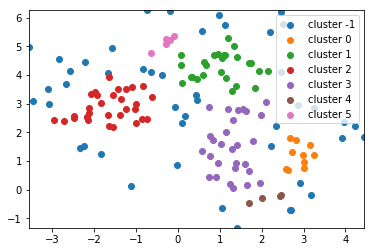

In [9]:
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=.5,min_samples=4,metric='euclidean')#epsやmin_samplesを調整する。
y_db=db.fit_predict(X)
clusters=np.unique(y_db)
for c in clusters:
    plt.scatter(X[y_db==c,0],X[y_db==c,1],label='cluster %d' % c)
plt.legend()
plt.xlim(X[:,0].min(),X[:,0].max())
plt.ylim(X[:,1].min(),X[:,1].max())

## 混合Gauss分布

混合正規分布に従ってサンプルが発生すると仮定する。
最尤推定で混合正規分布のパラメータを推定する。
EM algorithmによる推定。

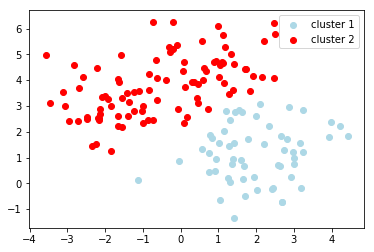

In [13]:
from sklearn import mixture
dpgmm = mixture.BayesianGaussianMixture(n_components=2,covariance_type='full')
y_dpgmm=dpgmm.fit(X).predict(X)
plt.scatter(X[y_dpgmm==0,0],X[y_dpgmm==0,1],c='lightblue',label='cluster 1')
plt.scatter(X[y_dpgmm==1,0],X[y_dpgmm==1,1],c='red',label='cluster 2')
plt.legend()

In [14]:
?mixture.BayesianGaussianMixture

moon dataで各手法の違いを見る。

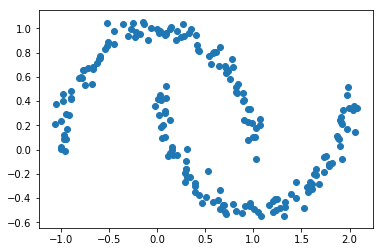

In [23]:
#三種類の手法の比較
from sklearn.datasets import make_moons
X,y=make_moons(n_samples=200,noise=0.05)
plt.scatter(X[:,0],X[:,1])

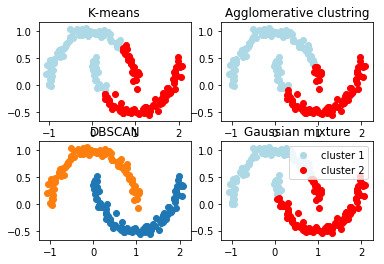

In [24]:
f,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2)
#KMeans
km=KMeans(n_clusters=2)
y_km=km.fit_predict(X)
ax1.scatter(X[y_km==0,0],X[y_km==0,1],c='lightblue',label='cluster 1')
ax1.scatter(X[y_km==1,0],X[y_km==1,1],c='red',label='cluster 2')
ax1.set_title('K-means')
#階層クラスタ
ac=AgglomerativeClustering(n_clusters=2,affinity='euclidean',linkage='complete')
y_ac=ac.fit_predict(X)
ax2.scatter(X[y_ac==0,0],X[y_ac==0,1],c='lightblue',label='cluster 1')
ax2.scatter(X[y_ac==1,0],X[y_ac==1,1],c='red',label='cluster 2')
ax2.set_title('Agglomerative clustring')
#DBSCAN
db=DBSCAN(eps=0.2,min_samples=5,metric='euclidean')
y_db=db.fit_predict(X)
clusters=np.unique(y_db)
for c in clusters:
    ax3.scatter(X[y_db==c,0],X[y_db==c,1],label='cluster %d' % c)
ax3.set_title('DBSCAN')
#混合ガウス
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
y_gmm=gmm.fit(X).predict(X)
ax4.scatter(X[y_gmm==0,0],X[y_gmm==0,1],c='lightblue',label='cluster 1')
ax4.scatter(X[y_gmm==1,0],X[y_gmm==1,1],c='red',label='cluster 2')
ax4.set_title('Gaussian mixture')

plt.legend()

データを乱数で生成して、各手法の違いを見る。

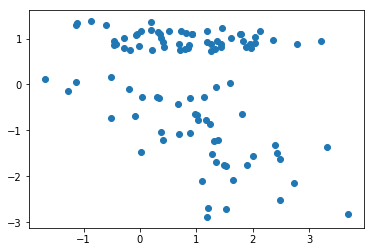

In [25]:
from sklearn import datasets
X,y=datasets.make_classification(n_samples=100,n_features=2,n_redundant=0,
                                 n_classes=2,n_clusters_per_class=1,random_state=0)
plt.scatter(X[:,0],X[:,1])

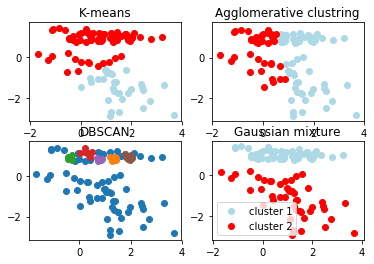

In [26]:
f,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2)
#KMeans
km=KMeans(n_clusters=2)
y_km=km.fit_predict(X)
ax1.scatter(X[y_km==0,0],X[y_km==0,1],c='lightblue',label='cluster 1')
ax1.scatter(X[y_km==1,0],X[y_km==1,1],c='red',label='cluster 2')
ax1.set_title('K-means')
#階層クラスタ
ac=AgglomerativeClustering(n_clusters=2,affinity='euclidean',linkage='complete')
y_ac=ac.fit_predict(X)
ax2.scatter(X[y_ac==0,0],X[y_ac==0,1],c='lightblue',label='cluster 1')
ax2.scatter(X[y_ac==1,0],X[y_ac==1,1],c='red',label='cluster 2')
ax2.set_title('Agglomerative clustring')
#DBSCAN
db=DBSCAN(eps=0.2,min_samples=5,metric='euclidean')
y_db=db.fit_predict(X)
clusters=np.unique(y_db)
for c in clusters:
    ax3.scatter(X[y_db==c,0],X[y_db==c,1],label='cluster %d' % c)
ax3.set_title('DBSCAN')
#混合ガウス
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
y_gmm=gmm.fit(X).predict(X)
ax4.scatter(X[y_gmm==0,0],X[y_gmm==0,1],c='lightblue',label='cluster 1')
ax4.scatter(X[y_gmm==1,0],X[y_gmm==1,1],c='red',label='cluster 2')
ax4.set_title('Gaussian mixture')

plt.legend()